In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [2]:
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

torch.device("cuda")

device(type='cuda')

In [3]:
from torchvision import transforms
h,w = 64,64
data_transform = transforms.Compose([
    transforms.Resize(size=(h,w)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

12


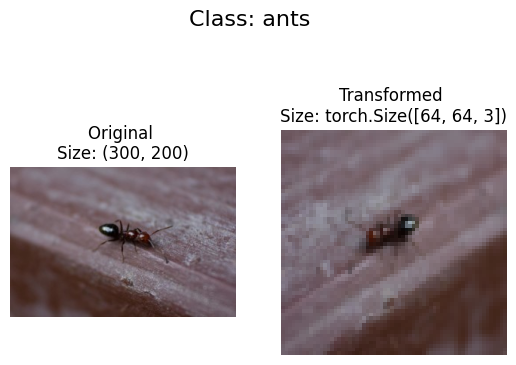

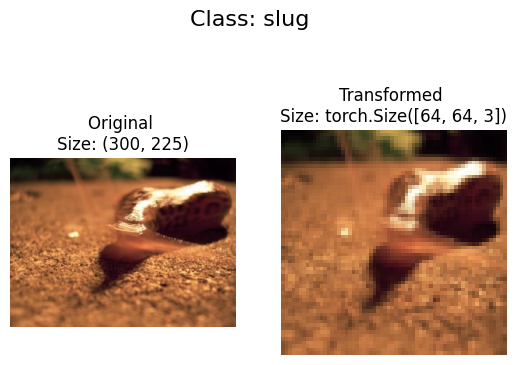

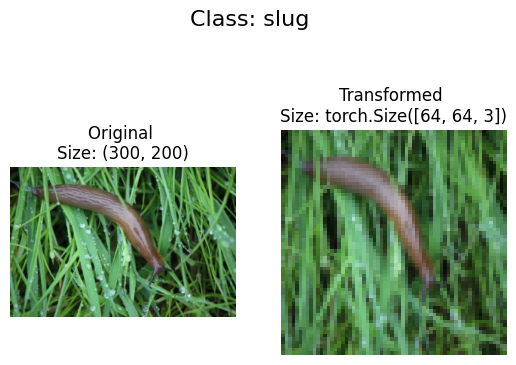

In [4]:
import random
from PIL import Image
from pathlib import Path


random.seed(42)

data_path = Path("Pest_Prediction_Pro/")
image_path = data_path / "Pest Prediction"
train_dir = image_path / "train"
test_dir = image_path / "test"
image_path_list = list(image_path.glob("*/*/*.jpg"))
num_subfolders = len([f for f in train_dir.iterdir() if f.is_dir()])

print(num_subfolders)
def plot_transformed_images(image_paths, transform, n=5, seed=11):
    seed = random.randint(1,100)
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [5]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

In [6]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True, num_workers=10,pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [7]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix,classification_report

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    losses = []  # List to store loss values for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    
    # Plotting using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, num_epochs + 1), y=losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    print('\nAccuracy on the test set: %d %%' % accuracy)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Compute classification report
    report = classification_report(all_labels, all_predictions, digits=4)
    print("Classification Report:")
    print(report)

def test_model2(model, test_loader, num_examples=5):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(torch.device('cuda')), labels.to(torch.device('cuda'))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
                
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions, digits=4)
    
    # Plotting accuracy
    plt.figure(figsize=(8, 6))
    plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
    plt.title('Accuracy on the test set')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.show()
    
    print('Accuracy on the test set: %.2f %%' % accuracy)
    print("Classification Report:")
    print(report)
    
    # Example predictions
    print("\nExample Predictions:")
    for i in range(num_examples):
        example_input, example_label = next(iter(test_loader))
        example_input = example_input[0].unsqueeze(0).to(torch.device('cuda'))
        example_output = model(example_input)
        _, example_prediction = torch.max(example_output.data, 1)
        
        # Display example input as an image
        plt.figure()
        plt.imshow(example_input.cpu().numpy().squeeze().transpose(1, 2, 0))  # Assuming input is in NCHW format
        plt.title("Example Input")
        plt.axis('off')
        plt.show()
        
        t = example_prediction.item()
        if t==1:
            t = "Real"
        else:
            t = "Fake"
        print("Predicted Label:", t)
        print()


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
num_epochs = 50
learn_rate = 0.001

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.c1 = nn.Conv2d(3,6,kernel_size=3)
        self.c2 = nn.Conv2d(6,16,kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,12)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
    def forward(self,x):
        x = self.norm1(self.pool(self.relu(self.c1(x))))
        x = self.norm2(self.pool(self.relu(self.c2(x))))
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/50, Loss: 2.2396896697472837
Epoch 2/50, Loss: 1.8524976018546284
Epoch 3/50, Loss: 1.6130624525788901
Epoch 4/50, Loss: 1.3909027904703997
Epoch 5/50, Loss: 1.1757704494655996
Epoch 6/50, Loss: 0.98591599257096
Epoch 7/50, Loss: 0.8330904357675193
Epoch 8/50, Loss: 0.6524854518365168
Epoch 9/50, Loss: 0.5120295281859412
Epoch 10/50, Loss: 0.42380804298580554
Epoch 11/50, Loss: 0.33594248152297473
Epoch 12/50, Loss: 0.2588129740046418
Epoch 13/50, Loss: 0.1866346076670764
Epoch 14/50, Loss: 0.15593099496934726
Epoch 15/50, Loss: 0.13113490497504454
Epoch 16/50, Loss: 0.08632089562066224
Epoch 17/50, Loss: 0.09861361535023087
Epoch 18/50, Loss: 0.10416362901636655
Epoch 19/50, Loss: 0.05926568394499845
Epoch 20/50, Loss: 0.05988021788821704
Epoch 21/50, Loss: 0.046531239362514534
Epoch 22/50, Loss: 0.03876185091887263
Epoch 23/50, Loss: 0.04149045288373811
Epoch 24/50, Loss: 0.06030416824733433
Epoch 25/50, Loss: 0.09058953211575314
Epoch 26/50, Loss: 0.14693942917105945
Epoch 2

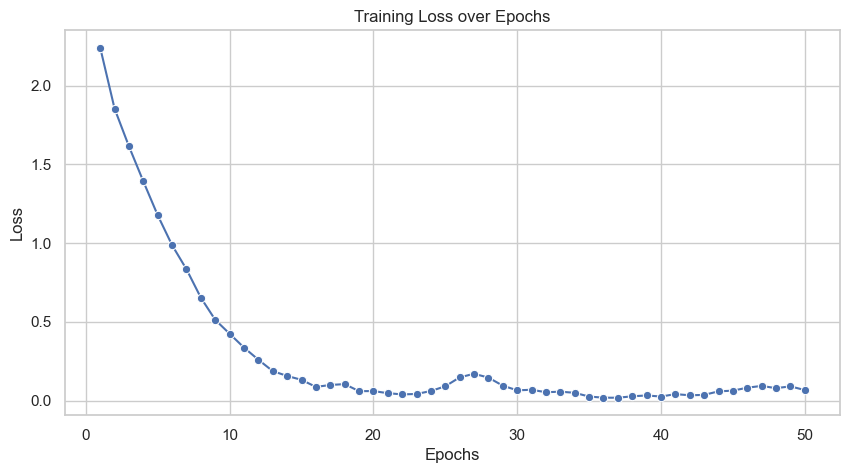


Accuracy on the test set: 36 %


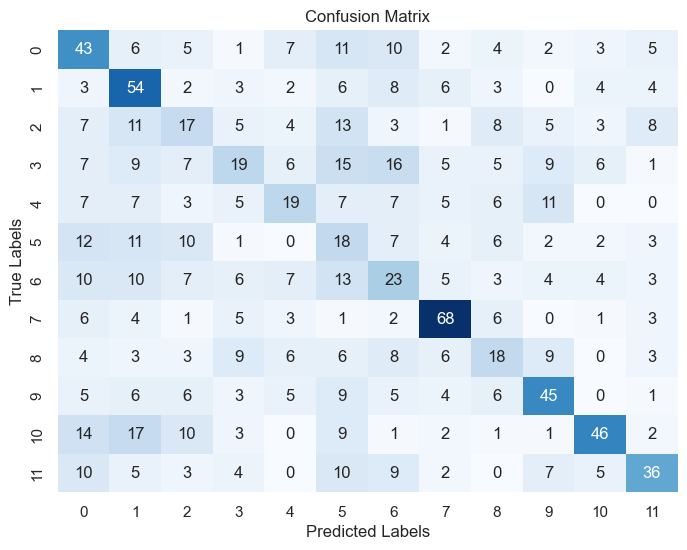

Classification Report:
              precision    recall  f1-score   support

           0     0.3359    0.4343    0.3789        99
           1     0.3776    0.5684    0.4538        95
           2     0.2297    0.2000    0.2138        85
           3     0.2969    0.1810    0.2249       105
           4     0.3220    0.2468    0.2794        77
           5     0.1525    0.2368    0.1856        76
           6     0.2323    0.2421    0.2371        95
           7     0.6182    0.6800    0.6476       100
           8     0.2727    0.2400    0.2553        75
           9     0.4737    0.4737    0.4737        95
          10     0.6216    0.4340    0.5111       106
          11     0.5217    0.3956    0.4500        91

    accuracy                         0.3694      1099
   macro avg     0.3713    0.3611    0.3593      1099
weighted avg     0.3812    0.3694    0.3681      1099



In [9]:
model1 = LeNet()
model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model1,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model1,test_dataloader)

In [10]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.c1 = nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2)
        self.c2 = nn.Conv2d(64,192,kernel_size=5,padding=2)
        self.c3 = nn.Conv2d(192,384,kernel_size=3,padding=1)
        self.c4 = nn.Conv2d(384,256,kernel_size=3,padding=1)
        self.c5 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3,stride=2)
        self.fc1 = nn.Linear(256*6*6,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,12)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten(1)
        self.drop = nn.Dropout()
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm2d(192)
        self.norm3 = nn.BatchNorm2d(384)
        self.norm4 = nn.BatchNorm2d(256)
        self.norm5 = nn.BatchNorm2d(256)
    def forward(self,x):
        x = self.norm1(self.pool(self.relu((self.c1(x)))))
        x = self.norm2(self.pool(self.relu((self.c2(x)))))
        x = self.norm3(self.relu((self.c3(x))))
        x = self.norm4(self.relu((self.c4(x))))
        x = self.norm5(self.relu((self.c5(x))))
        x = self.pool(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.relu(self.fc1(self.drop(x)))
        x = self.relu(self.fc2(self.drop(x)))
        x = self.fc3(x)
        return x

: 

In [11]:
model2 = AlexNet()
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model2,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model2,test_dataloader)

Epoch 1/50, Loss: 4.765769796095032
Epoch 2/50, Loss: 2.46838467017464
Epoch 3/50, Loss: 2.4529592956321826
Epoch 4/50, Loss: 2.4430754841237827
Epoch 5/50, Loss: 2.4676892999289692
Epoch 6/50, Loss: 2.4208005960436836
Epoch 7/50, Loss: 2.4565097456393032
Epoch 8/50, Loss: 2.4725243941597315
Epoch 9/50, Loss: 2.4166899936786597
Epoch 10/50, Loss: 2.3460571800453076
Epoch 11/50, Loss: 2.344480137894119
Epoch 12/50, Loss: 2.3135024430095283
Epoch 13/50, Loss: 2.3169646608656733
Epoch 14/50, Loss: 2.2534466273542764
Epoch 15/50, Loss: 2.2312287973321
Epoch 16/50, Loss: 2.2278362426204956
Epoch 17/50, Loss: 2.1507186388623887
Epoch 18/50, Loss: 2.149162470430568
Epoch 19/50, Loss: 2.0982045263483906
Epoch 20/50, Loss: 2.0850446517916694
Epoch 21/50, Loss: 2.0116108362225518
Epoch 22/50, Loss: 1.9843007896257483
Epoch 23/50, Loss: 1.9641312550807344
Epoch 24/50, Loss: 1.913560354191324
Epoch 25/50, Loss: 1.8806128570998923
Epoch 26/50, Loss: 1.8411721336668816
Epoch 27/50, Loss: 1.827787110

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



Epoch 1/50, Loss: 2.6179262486057007
Epoch 2/50, Loss: 2.4630966808484946
Epoch 3/50, Loss: 2.462788108466328
Epoch 4/50, Loss: 2.4368412183678667
Epoch 5/50, Loss: 2.4642252438310264
Epoch 6/50, Loss: 2.4170290940049766
Epoch 7/50, Loss: 2.3961635119673135
Epoch 8/50, Loss: 2.3680174488952193
Epoch 9/50, Loss: 2.4320232937301416
Epoch 10/50, Loss: 2.3283922326737554
Epoch 11/50, Loss: 2.2977767992710723
Epoch 12/50, Loss: 2.26336639860402
Epoch 13/50, Loss: 2.254123193630274
Epoch 14/50, Loss: 2.2525520670241206
Epoch 15/50, Loss: 2.211814016535662
Epoch 16/50, Loss: 2.1920243277065996
Epoch 17/50, Loss: 2.2026249930478525
Epoch 18/50, Loss: 2.217999323554661
Epoch 19/50, Loss: 2.1514628797337627
Epoch 20/50, Loss: 2.1622338087662407
Epoch 21/50, Loss: 2.1530051386874653
Epoch 22/50, Loss: 2.18167457546013
Epoch 23/50, Loss: 2.1522320560787036
Epoch 24/50, Loss: 2.1100533475046572
Epoch 25/50, Loss: 2.112585428832234
Epoch 26/50, Loss: 2.077683396961378
Epoch 27/50, Loss: 2.0960241383

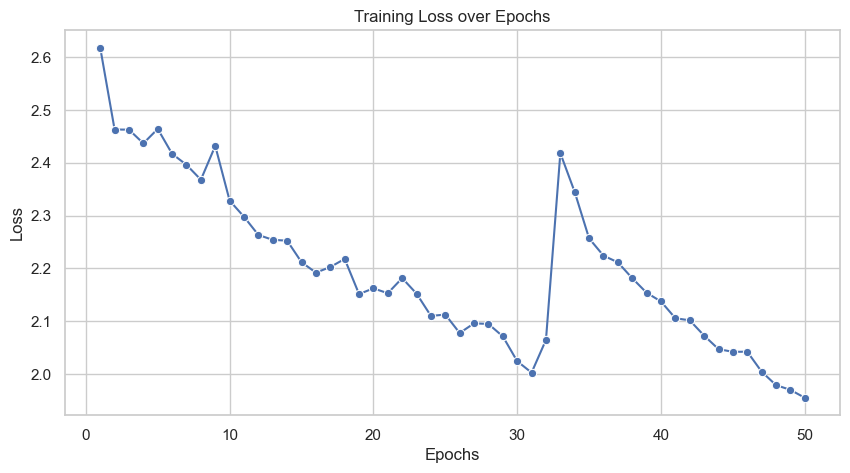


Accuracy on the test set: 30 %


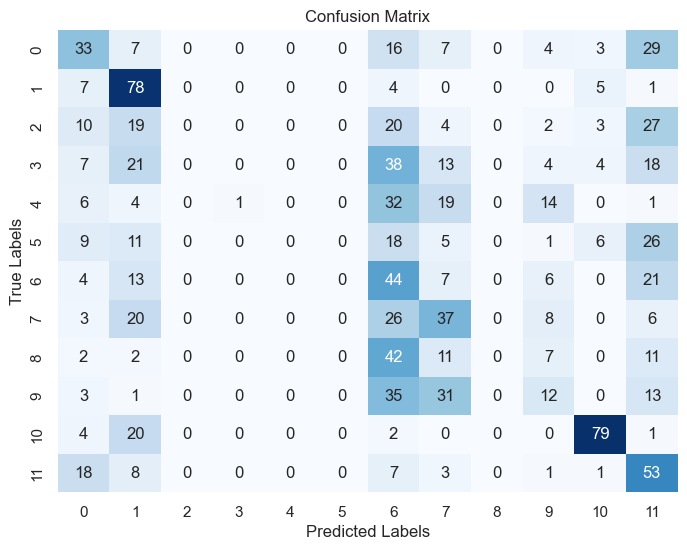

Classification Report:
              precision    recall  f1-score   support

           0     0.3113    0.3333    0.3220        99
           1     0.3824    0.8211    0.5217        95
           2     0.0000    0.0000    0.0000        85
           3     0.0000    0.0000    0.0000       105
           4     0.0000    0.0000    0.0000        77
           5     0.0000    0.0000    0.0000        76
           6     0.1549    0.4632    0.2322        95
           7     0.2701    0.3700    0.3122       100
           8     0.0000    0.0000    0.0000        75
           9     0.2034    0.1263    0.1558        95
          10     0.7822    0.7453    0.7633       106
          11     0.2560    0.5824    0.3557        91

    accuracy                         0.3057      1099
   macro avg     0.1967    0.2868    0.2219      1099
weighted avg     0.2133    0.3057    0.2391      1099



c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
model3 = VGG16()
model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model3,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model3,test_dataloader)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


Epoch 1/50, Loss: 2.296016190363013
Epoch 2/50, Loss: 1.9872088017671004
Epoch 3/50, Loss: 1.8557519774506057
Epoch 4/50, Loss: 1.7228892661523127
Epoch 5/50, Loss: 1.5754109621047974
Epoch 6/50, Loss: 1.4788701499717822
Epoch 7/50, Loss: 1.363134009250696
Epoch 8/50, Loss: 1.2631362970324531
Epoch 9/50, Loss: 1.1743714878524558
Epoch 10/50, Loss: 1.0288697973541592
Epoch 11/50, Loss: 0.9613630961680758
Epoch 12/50, Loss: 0.8406410510989203
Epoch 13/50, Loss: 0.6780070217623226
Epoch 14/50, Loss: 0.6147619442663331
Epoch 15/50, Loss: 0.556638401919517
Epoch 16/50, Loss: 0.4565757614546928
Epoch 17/50, Loss: 0.36579806368420087
Epoch 18/50, Loss: 0.30179806636727374
Epoch 19/50, Loss: 0.28136589064978174
Epoch 20/50, Loss: 0.22145275231720746
Epoch 21/50, Loss: 0.19085923215185385
Epoch 22/50, Loss: 0.21098375784746115
Epoch 23/50, Loss: 0.1472104518417863
Epoch 24/50, Loss: 0.12645789951194022
Epoch 25/50, Loss: 0.1297374139877333
Epoch 26/50, Loss: 0.12289475708983946
Epoch 27/50, Los

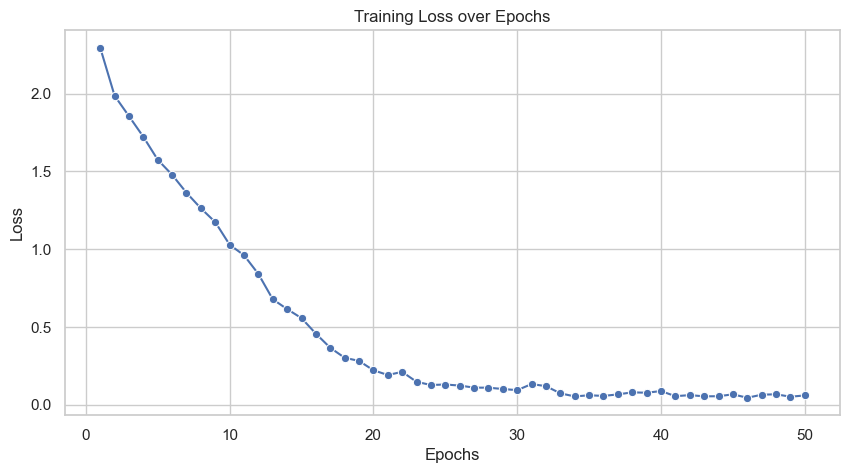


Accuracy on the test set: 30 %


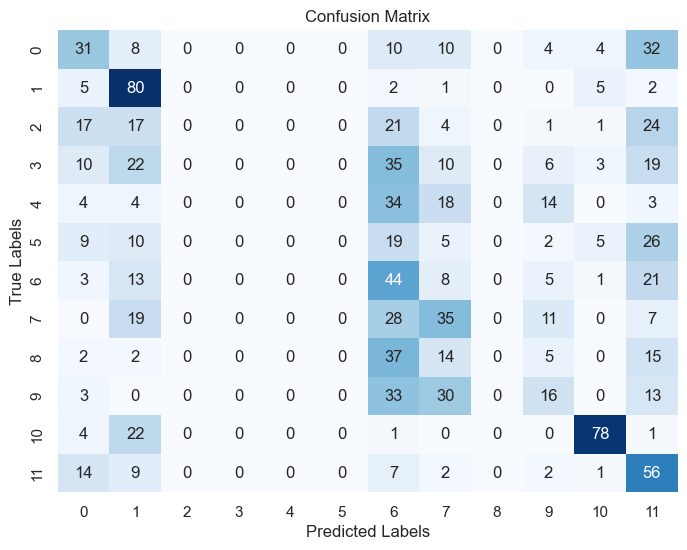

Classification Report:
              precision    recall  f1-score   support

           0     0.3039    0.3131    0.3085        99
           1     0.3883    0.8421    0.5316        95
           2     0.0000    0.0000    0.0000        85
           3     0.0000    0.0000    0.0000       105
           4     0.0000    0.0000    0.0000        77
           5     0.0000    0.0000    0.0000        76
           6     0.1624    0.4632    0.2404        95
           7     0.2555    0.3500    0.2954       100
           8     0.0000    0.0000    0.0000        75
           9     0.2424    0.1684    0.1988        95
          10     0.7959    0.7358    0.7647       106
          11     0.2557    0.6154    0.3613        91

    accuracy                         0.3094      1099
   macro avg     0.2003    0.2907    0.2250      1099
weighted avg     0.2171    0.3094    0.2422      1099



c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
def ResNet18(num_classes=12):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

model4 = ResNet18()
model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model4,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model3,test_dataloader)

In [ ]:
import torch.nn.functional as F

class Inception(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out_pool):
        super(Inception, self).__init__()
        
        # 1x1 convolution
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1),
            nn.BatchNorm2d(out1x1),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 convolution followed by 3x3 convolution
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.BatchNorm2d(red3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out3x3),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 convolution followed by 5x5 convolution
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.BatchNorm2d(red5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out5x5),
            nn.ReLU(inplace=True)
        )
        
        # 3x3 max pooling followed by 1x1 convolution
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)
    
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=12):
        super(GoogLeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True)
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


In [ ]:
model5 = GoogLeNet(num_classes=12)
model5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model5,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model5,test_dataloader)

c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shyam\OneDrive\Desktop\DL_prac\PyTorch_Tut\.myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\shyam/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:52<00:00, 1.95MB/s]


Epoch 1/50, Loss: 1.6434498930322952
Epoch 2/50, Loss: 1.1462835427643596
Epoch 3/50, Loss: 0.9666445747665737
Epoch 4/50, Loss: 0.7675449174383412
Epoch 5/50, Loss: 0.6652941457603289
Epoch 6/50, Loss: 0.5176625601623369
Epoch 7/50, Loss: 0.5111909080026806
Epoch 8/50, Loss: 0.43883133236912714
Epoch 9/50, Loss: 0.3510866597078849
Epoch 10/50, Loss: 0.27865006180777063
Epoch 11/50, Loss: 0.2609116518195125
Epoch 12/50, Loss: 0.23762910483755928
Epoch 13/50, Loss: 0.18134015760775926
Epoch 14/50, Loss: 0.1838039774717628
Epoch 15/50, Loss: 0.1612897239409495
Epoch 16/50, Loss: 0.13843288993381936
Epoch 17/50, Loss: 0.16644457187773526
Epoch 18/50, Loss: 0.154150342217822
Epoch 19/50, Loss: 0.13096952891868094
Epoch 20/50, Loss: 0.11907529566383017
Epoch 21/50, Loss: 0.11652160727459451
Epoch 22/50, Loss: 0.13188021603053895
Epoch 23/50, Loss: 0.10179594350789768
Epoch 24/50, Loss: 0.10147968145168346
Epoch 25/50, Loss: 0.06623807076391751
Epoch 26/50, Loss: 0.07597522573896508
Epoch 27

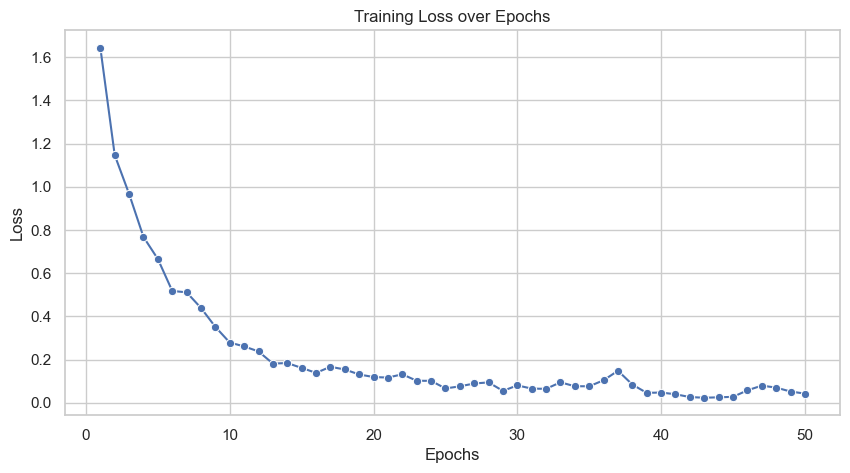


Accuracy on the test set: 61 %


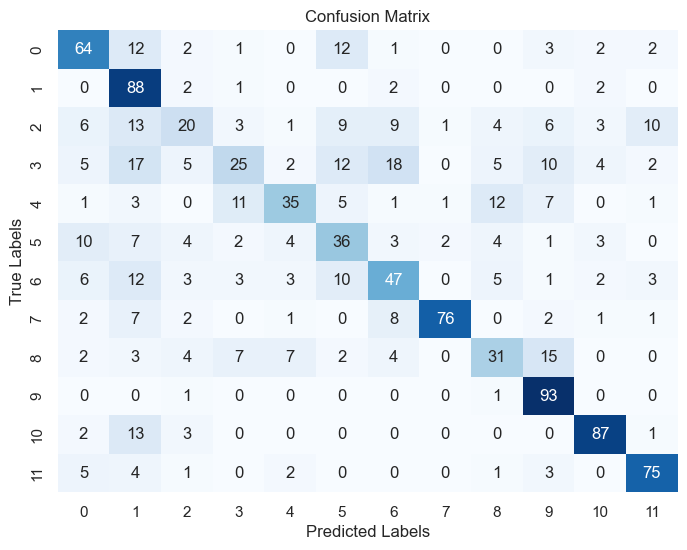

Classification Report:
              precision    recall  f1-score   support

           0     0.6214    0.6465    0.6337        99
           1     0.4916    0.9263    0.6423        95
           2     0.4255    0.2353    0.3030        85
           3     0.4717    0.2381    0.3165       105
           4     0.6364    0.4545    0.5303        77
           5     0.4186    0.4737    0.4444        76
           6     0.5054    0.4947    0.5000        95
           7     0.9500    0.7600    0.8444       100
           8     0.4921    0.4133    0.4493        75
           9     0.6596    0.9789    0.7881        95
          10     0.8365    0.8208    0.8286       106
          11     0.7895    0.8242    0.8065        91

    accuracy                         0.6160      1099
   macro avg     0.6082    0.6055    0.5906      1099
weighted avg     0.6168    0.6160    0.5997      1099



In [8]:
import torchvision.models as models


model6 = models.resnet50(pretrained=True)
num_ftrs = model6.fc.in_features
model6.fc = nn.Linear(num_ftrs, 12)
model6.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model6.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model6,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model6,test_dataloader)

In [9]:
model7 = models.densenet121(weights="DenseNet121_Weights.DEFAULT")
num_ftrs = model7.classifier.in_features
model7.classifier = nn.Linear(num_ftrs, 12)
model7.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model7.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model7,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model7,test_dataloader)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\shyam/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:43<00:00, 750kB/s] 


Epoch 1/50, Loss: 1.4494298636049465
Epoch 2/50, Loss: 0.9278841627680737
Epoch 3/50, Loss: 0.7596779508867125
Epoch 4/50, Loss: 0.6474780379862025
Epoch 5/50, Loss: 0.5422251185645228
Epoch 6/50, Loss: 0.4761019310225611
Epoch 7/50, Loss: 0.4069241257249445
Epoch 8/50, Loss: 0.3835536476926527
Epoch 9/50, Loss: 0.31670023069001624
Epoch 10/50, Loss: 0.25412468579800235
Epoch 11/50, Loss: 0.24222669523695242
Epoch 12/50, Loss: 0.28412340284473653
Epoch 13/50, Loss: 0.2362476452321246
Epoch 14/50, Loss: 0.17036715570999228
Epoch 15/50, Loss: 0.12649489423611027
Epoch 16/50, Loss: 0.1411087607451971
Epoch 17/50, Loss: 0.1559036317942799
Epoch 18/50, Loss: 0.13766334027699803
Epoch 19/50, Loss: 0.15687882813854495
Epoch 20/50, Loss: 0.16738127692994
Epoch 21/50, Loss: 0.10020778788442629
Epoch 22/50, Loss: 0.08525268298209361
Epoch 23/50, Loss: 0.11371397737251676
Epoch 24/50, Loss: 0.1177210272492274
Epoch 25/50, Loss: 0.12238419844188551
Epoch 26/50, Loss: 0.15641841470547344
Epoch 27/5

KeyboardInterrupt: 

Epoch 1/50, Loss: 2.353991042012754
Epoch 2/50, Loss: 2.1202343322228696
Epoch 3/50, Loss: 1.9151845444803652
Epoch 4/50, Loss: 1.718496574871782
Epoch 5/50, Loss: 1.5401809526526409
Epoch 6/50, Loss: 1.358047606288523
Epoch 7/50, Loss: 1.2017968461133433
Epoch 8/50, Loss: 1.04691161280093
Epoch 9/50, Loss: 0.8690421710843625
Epoch 10/50, Loss: 0.7574384532113007
Epoch 11/50, Loss: 0.6012015092200127
Epoch 12/50, Loss: 0.4619026410838832
Epoch 13/50, Loss: 0.408953999047694
Epoch 14/50, Loss: 0.35920164053854736
Epoch 15/50, Loss: 0.28344067898781405
Epoch 16/50, Loss: 0.2698621618143026
Epoch 17/50, Loss: 0.24210573819236478
Epoch 18/50, Loss: 0.2371253596915715
Epoch 19/50, Loss: 0.21271029373873834
Epoch 20/50, Loss: 0.1773948234276495
Epoch 21/50, Loss: 0.18104207002814265
Epoch 22/50, Loss: 0.1848037987947464
Epoch 23/50, Loss: 0.14904122059975844
Epoch 24/50, Loss: 0.11907214104481366
Epoch 25/50, Loss: 0.10373080786371576
Epoch 26/50, Loss: 0.10087337182915729
Epoch 27/50, Loss:

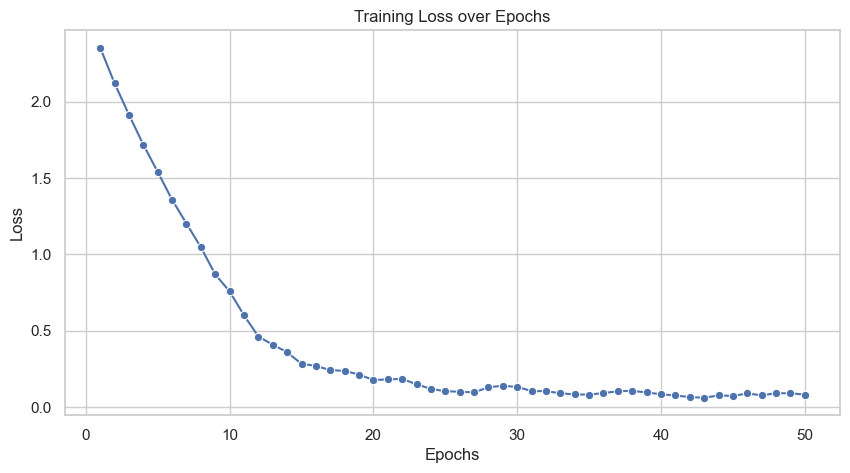


Accuracy on the test set: 40 %


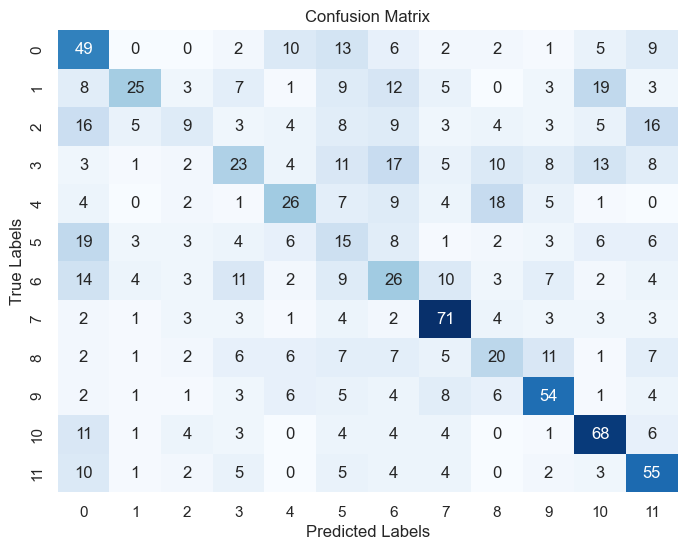

Classification Report:
              precision    recall  f1-score   support

           0     0.3500    0.4949    0.4100        99
           1     0.5814    0.2632    0.3623        95
           2     0.2647    0.1059    0.1513        85
           3     0.3239    0.2190    0.2614       105
           4     0.3939    0.3377    0.3636        77
           5     0.1546    0.1974    0.1734        76
           6     0.2407    0.2737    0.2562        95
           7     0.5820    0.7100    0.6396       100
           8     0.2899    0.2667    0.2778        75
           9     0.5347    0.5684    0.5510        95
          10     0.5354    0.6415    0.5837       106
          11     0.4545    0.6044    0.5189        91

    accuracy                         0.4013      1099
   macro avg     0.3922    0.3902    0.3791      1099
weighted avg     0.4005    0.4013    0.3886      1099



In [ ]:
model8 = models.densenet201(weight="DenseNet201_Weights.DEFAULT")
num_ftrs = model8.classifier.in_features
model8.classifier = nn.Linear(num_ftrs, 12)
model8.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model8.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model8,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model8,test_dataloader)

Epoch 1/50, Loss: 2.476094767667245
Epoch 2/50, Loss: 2.4473711891450742
Epoch 3/50, Loss: 2.4322572410970493
Epoch 4/50, Loss: 2.42861665159032
Epoch 5/50, Loss: 2.4210882843404575
Epoch 6/50, Loss: 2.401350474012071
Epoch 7/50, Loss: 2.389595968135889
Epoch 8/50, Loss: 2.357242781182994
Epoch 9/50, Loss: 2.3258731192436772
Epoch 10/50, Loss: 2.3068514250326846
Epoch 11/50, Loss: 2.257092316945394
Epoch 12/50, Loss: 2.218357450720193
Epoch 13/50, Loss: 2.181987420372341
Epoch 14/50, Loss: 2.1323669025863428
Epoch 15/50, Loss: 2.0563575409460757
Epoch 16/50, Loss: 2.011149012524149
Epoch 17/50, Loss: 1.961553732554118
Epoch 18/50, Loss: 1.9165829972944397
Epoch 19/50, Loss: 1.8368742137715437
Epoch 20/50, Loss: 1.7764545143514439
Epoch 21/50, Loss: 1.715925021447997
Epoch 22/50, Loss: 1.6596991462983948
Epoch 23/50, Loss: 1.6096530306166497
Epoch 24/50, Loss: 1.5634819441947385
Epoch 25/50, Loss: 1.4935959525730298
Epoch 26/50, Loss: 1.3998849996622058
Epoch 27/50, Loss: 1.353508607200

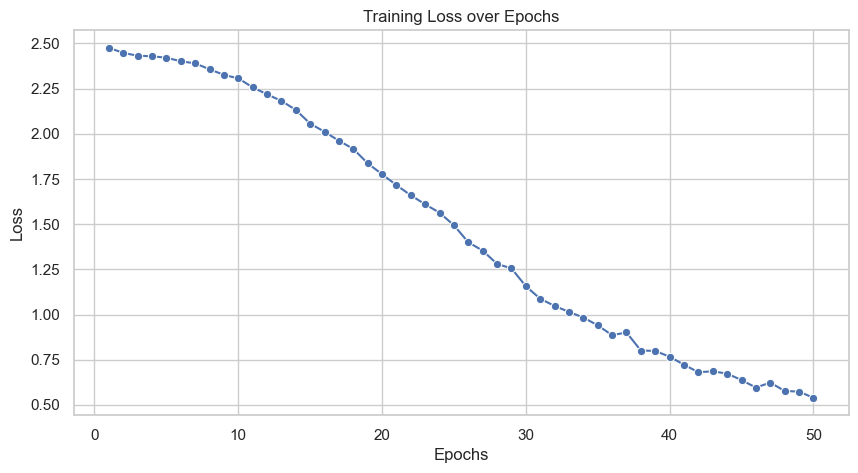


Accuracy on the test set: 23 %


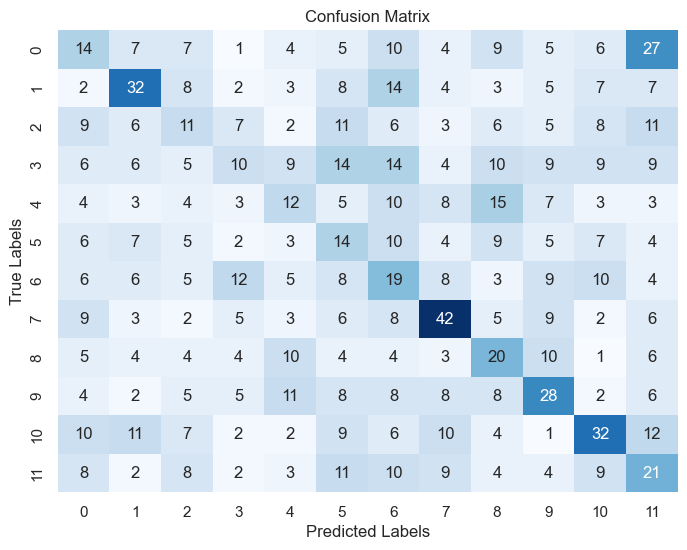

Classification Report:
              precision    recall  f1-score   support

           0     0.1687    0.1414    0.1538        99
           1     0.3596    0.3368    0.3478        95
           2     0.1549    0.1294    0.1410        85
           3     0.1818    0.0952    0.1250       105
           4     0.1791    0.1558    0.1667        77
           5     0.1359    0.1842    0.1564        76
           6     0.1597    0.2000    0.1776        95
           7     0.3925    0.4200    0.4058       100
           8     0.2083    0.2667    0.2339        75
           9     0.2887    0.2947    0.2917        95
          10     0.3333    0.3019    0.3168       106
          11     0.1810    0.2308    0.2029        91

    accuracy                         0.2320      1099
   macro avg     0.2286    0.2298    0.2266      1099
weighted avg     0.2334    0.2320    0.2301      1099



In [ ]:
model9 = models.efficientnet_b0(weights=None)
num_ftrs = model9.classifier[1].in_features
model9.classifier[1] = nn.Linear(num_ftrs, 12)
model9.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model9.parameters(), lr=learn_rate)

torch.cuda.empty_cache()
train_model(model9,train_dataloader, criterion, optimizer, num_epochs=num_epochs)
torch.cuda.empty_cache()
test_model(model9,test_dataloader)